In [1]:
import json
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler
from IPython.display import display


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
binary_path: C:\Users\user\AppData\Roaming\Python\Python310\site-packages\bitsandbytes\cuda_setup\libbitsandbytes_cuda116.dll
CUDA SETUP: Loading binary C:\Users\user\AppData\Roaming\Python\Python310\site-packages\bitsandbytes\cuda_setup\libbitsandbytes_cuda116.dll...


In [2]:
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

NVIDIA GeForce RTX 4070 Ti, 12282 MiB, 11524 MiB


In [3]:
torch.cuda.empty_cache()
torch.cuda.is_available()

True

In [4]:
#!pip install -U -r requirements.txt
#%pip install -q -U --pre triton

# Fine-tune

In [15]:
concepts_list = [
    {
        "instance_prompt":      "photo of potter boss",
        "class_prompt":         "photo of a person",
        "instance_data_dir":    "data/ytr", # training images
        "class_data_dir":       "data/person" # this contains regularization images
    }
]

with open("concepts_list.json", "w") as f:
    json.dump(concepts_list, f, indent=4)

In [16]:
# fine-tune model
!python train_dreambooth.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
  --pretrained_vae_name_or_path="stabilityai/sd-vae-ft-mse" \
  --output_dir="model" \
  --revision="fp16" \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --seed=1337 \
  --resolution=512 \
  --train_batch_size=1 \
  --train_text_encoder \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=50 \
  --sample_batch_size=4 \
  --max_train_steps=800 \
  --save_interval=10000 \
  --save_sample_prompt="photo of ytr boss" \
  --concepts_list="concepts_list.json"


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
binary_path: C:\Users\user\AppData\Roaming\Python\Python310\site-packages\bitsandbytes\cuda_setup\libbitsandbytes_cuda116.dll
CUDA SETUP: Loading binary C:\Users\user\AppData\Roaming\Python\Python310\site-packages\bitsandbytes\cuda_setup\libbitsandbytes_cuda116.dll...
[*] Weights saved at model\800


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\diffusers\configuration_utils.py:239: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)

Caching latents: 100%|██████████| 50/50 [00:08<00:00,  5.58it/s]
09/22/2023 20:11:23 - INFO - __main__ - ***** Running training *****
09/22/2023 20:11:23 - INFO - __main__ -   Num examples = 50
09/22/2023 20:11:23 - INFO - __main__ -   Num batches each epoch = 50
09/22/2023 20:11:23 - INFO - __main__ -   Num Epochs = 16
09/22/2023 20:11:23 - INFO - __main__ -   Instantaneous batch size per device = 1
09/22/2023 20:11:23 - INFO - __main__ -   Total train batch

In [17]:
# convert diffuser to ckpt
!python convert_diffusers_to_original_stable_diffusion.py --model_path model/800 --checkpoint_path model/800/fine_tuned.ckpt --half

# Inference

In [18]:
# load fine-tuned model
#model_path = "runwayml/stable-diffusion-v1-5"
model_path = "model/800/"
pipe = StableDiffusionPipeline.from_pretrained(model_path, safety_checker=None, torch_dtype=torch.float16).to("cuda")
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [19]:
g_cuda = torch.Generator(device='cuda')
g_cuda.manual_seed(52362)

  0%|          | 0/24 [00:00<?, ?it/s]

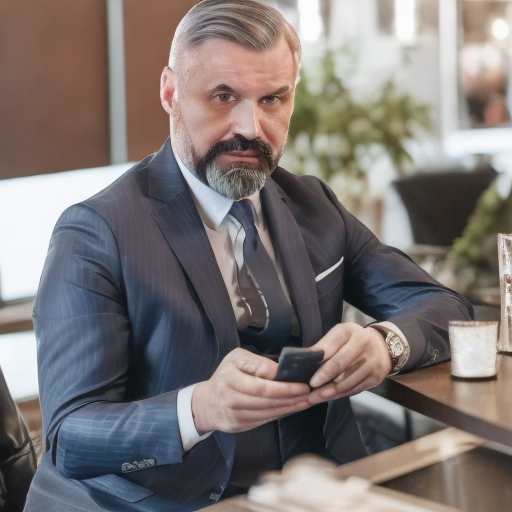

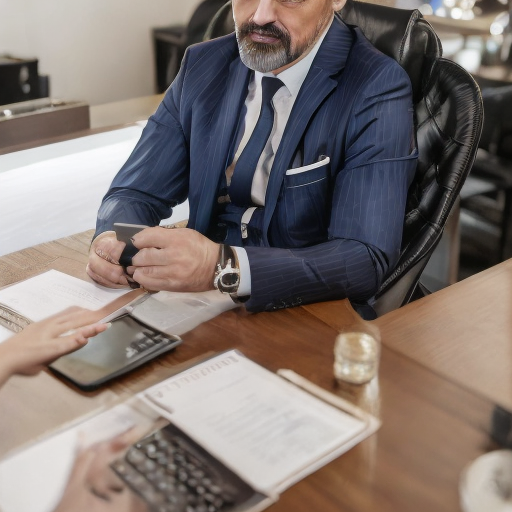

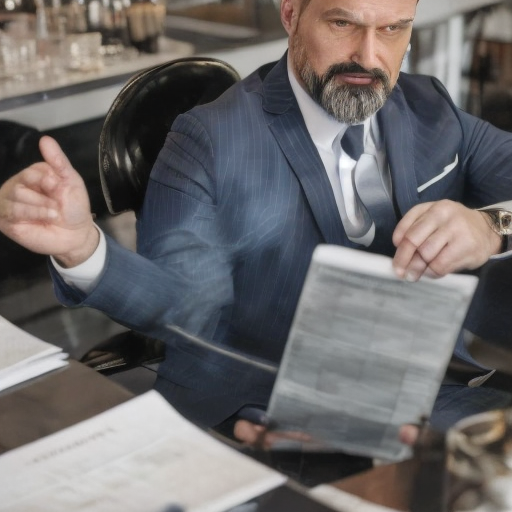

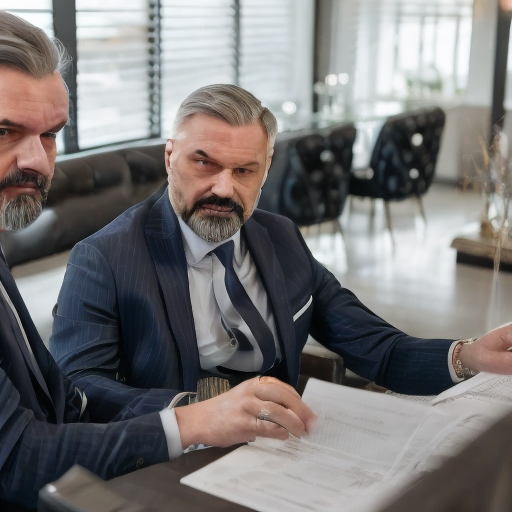

In [23]:
# prompt parameters
prompt = "ytr boss in a pool"
negative_prompt = ""
num_samples = 4
guidance_scale = 7.5
num_inference_steps = 24
height = 512
width = 512

# torch inference
with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

# show image
for img in images:
    display(img)